In [35]:
! pip install treelib

In [36]:
import networkx as nx
from treelib import Node, Tree
from google.colab import drive
import statistics
import re
import math
import matplotlib.pyplot as plt

In [37]:
drive.mount('/content/drive', force_remount=True)
path_file = "/content/drive/MyDrive/Learning From Networks/amazon-meta.txt"

Mounted at /content/drive


# Set-up
First of all we define functions to build a dictionary of books and the tree of genres. Attention: we limit ourselves to the "Subjects" subcategory of "Books", since the other subcategories contained useless meta informations (like Publisher, Formats, Shops etc etc)

In [38]:
def get_tree_categories(filename, filter="Subjects"):
    """
    Function that parse the graph in order to build the tree of categories.
    """

    file = open(filename)
    lines = file.readlines()
    categories = Tree()
    categories.create_node("Books", "Books", data={"high": {"salesrank": 0, "cc": 0}, "low": {"salesrank": 0, "cc": 0}})
    i = 0
    while i < len(lines):
      if "group: Book" in lines[i]: # it is a book
        while "categories" not in lines[i]: # arrive at the category
          i += 1
        i += 1 # skip the row of the number of categories
        while "reviews" not in lines[i]: # till the last category
          splitted = lines[i].rstrip().split("|")
          previous = "Books"
          if "Specialty Stores" in lines[i] or "Books" not in lines[i] or filter not in lines[i]:
            i+=1
            continue
          if len(splitted) > 2: # if we have a subcategory of Books
            for j in range(2, len(splitted)):
              category = splitted[j].strip()
              name = re.sub("\[.*\]$", "", category)
              if not categories.contains(category): # cannot create node with same identifier
                categories.create_node(tag = name, identifier = category, parent = previous, data={"high": {"salesrank": 0, "cc": 0}, "low": {"salesrank": 0, "cc": 0}})
              previous = category
            i += 1
          else:
            i += 1
      else:
        i += 1

    file.close()
    return categories

In [39]:
def parsing_graph(filename, filter="Subjects"):
    """
    Function that parse the graph in order to build the dictionary of books,
    which will contain information like id, salesrank, most-specific subgenres
    and the co-purchased items
    """

    dictionary = {}
    file = open(filename)
    lines = file.readlines()
    file.close()
    elements = []
    j = 0
    for i in range(len(lines)):
      if lines[i] == "\n":
        elements.append(lines[j:i])
        j = i + 1

    for element in elements:
      if len(element) >= 4:
        if "Id:" in element[0] and "group: Book" in element[3]:
            id = element[0][6:-1]
            if "ASIN" in element[1]:
                asin = element[1][6:-1]
                if "salesrank:" in element[4]:
                    salesrank = element[4][13:-1]
                if "similar" in element[5]:
                    if element[5][11:13] != "0":
                        similar = element[5][14:-1].split("  ")
                    else:
                        similar = []
                    if "categories:" in element[6]:
                      i = 7
                      finalCategories = []
                      while "reviews" not in element[i]:
                        if "Specialty Stores" in element[i] or "Books" not in element[i] or filter not in element[i]:
                          i+=1
                          continue
                        if filter in element[i] and "Books" in element[i]:
                          categories = element[i][4:].split("|")
                          finalCategories.append(categories[-1].strip())
                        i += 1
                    dictionary[asin] = [id, salesrank, finalCategories, similar]

    return dictionary

After defining the parsing functions, we initialize both the dictionary and the tree, and then print some meta information on our data, as well as set up the co-purchase network

In [40]:
dictionary = parsing_graph(path_file)
print(len(dictionary.keys()))

393561


Build the graph starting from the dictionary obtained from the parsing

In [41]:
G_meta = nx.Graph()
for key in dictionary.keys():
  G_meta.add_node(key)

for key in dictionary.keys():
  toRemove = []
  for opposite in dictionary[key][3]:
    if opposite in dictionary.keys():
      G_meta.add_edge(key, opposite)
    else:
      toRemove.append(opposite)
  for opposite in toRemove: # remove from similar so the dictionary contains only books
    dictionary[key][3].remove(opposite)

In [42]:
print("Number of nodes: ", len(G_meta.nodes()))
print("Number of edges: ", len(G_meta.edges()))

Number of nodes:  393561
Number of edges:  741124


Compute the clustering coefficient

In [43]:
clust = nx.clustering(G_meta)
avg = nx.average_clustering(G_meta)
print("Average clustering coefficient: ", avg)
above_average = len([key for key in clust.keys() if clust[key] >= avg])
print("Number of elements above average:", above_average)
print("Percentage above average: ", above_average/len(clust.keys()) * 100, "%")

Average clustering coefficient:  0.276586517707083
Number of elements above average: 162670
Percentage above average:  41.332855643724855 %


In [44]:
avg = 0
for key in dictionary.keys():
  avg += int(dictionary[key][1])
avg /= len(dictionary.keys())
print("Average salesrank: ", avg)
above_average = len([key for key in dictionary.keys() if int(dictionary[key][1]) >= avg])
print("Number of elements above average:", above_average)
print("Percentage above average: ", above_average/len(clust.keys()) * 100, "%")

Average salesrank:  630906.8797213138
Number of elements above average: 146104
Percentage above average:  37.12359710438788 %


Obtain the tree of categories using the function above

In [45]:
cat_Tree = get_tree_categories(path_file)
print(cat_Tree.show(stdout=False))

Books
└── Subjects
    ├── Arts & Photography
    │   ├── Art
    │   │   ├── Art History
    │   │   │   ├── Criticism
    │   │   │   ├── General
    │   │   │   ├── Regional
    │   │   │   │   ├── African
    │   │   │   │   ├── African American
    │   │   │   │   ├── Asian
    │   │   │   │   ├── Canadian
    │   │   │   │   ├── Caribbean & Latin American
    │   │   │   │   ├── European
    │   │   │   │   ├── Middle Eastern
    │   │   │   │   ├── Native American
    │   │   │   │   └── United States
    │   │   │   └── Schools, Periods & Styles
    │   │   │       ├── Abstract Expressionism
    │   │   │       ├── Ancient & Classical
    │   │   │       ├── Baroque
    │   │   │       ├── Byzantine
    │   │   │       ├── Constructivism
    │   │   │       ├── Cubism
    │   │   │       ├── Dada
    │   │   │       ├── Futurism
    │   │   │       ├── German Expressionism
    │   │   │       ├── Gothic
    │   │   │       ├── Impressionism
    │   │   │       ├── Mannerism
   

In [46]:
print("Size of the tree: ", cat_Tree.size())
print("Depth of the tree: ", cat_Tree.depth())

Size of the tree:  11629
Depth of the tree:  7


# Analysis on above/below average and quantiles

Note that in from this point on invalid data is usually not considered, like books with -1 salesrank or 0 local cc

---



Get the quantile values for the salesrank and save them as bounds in sr_bounds

In [47]:
data2 = [int(dictionary[key][1]) for key in dictionary.keys() if int(dictionary[key][1]) >= 0]
print("Variance", statistics.variance(data2))
print("Mean", statistics.mean(data2))
print("Quantiles (3 steps)", statistics.quantiles(data2, n=3))

sr_avg = statistics.mean(data2)
sr_bounds = statistics.quantiles(data2, n=3)
sr_bounds.reverse()
print(sr_bounds)

Variance 365279958545.85583
Mean 631505.39401762
Quantiles (3 steps) [285111.0, 690611.0]
[690611.0, 285111.0]


Get the quantiles values for the clustering coefficient and save them as bounds in cc_bounds

In [48]:
data1 = [clust[key] for key in clust]
print("Variance", statistics.variance(data1))
print("Mean", statistics.mean(data1))
print("Quantiles (3 steps)", statistics.quantiles(data1, n=5, method="inclusive"))

cc_avg = statistics.mean(data1)

print("Quantiles (3 steps)", statistics.quantiles([clust[key] for key in clust if clust[key] > 0], n=3, method="inclusive"))

cc_bounds = statistics.quantiles([clust[key] for key in clust if clust[key] > 0], n=3, method="inclusive")
cc_bounds.reverse()
print(cc_bounds)

Variance 0.11201149488320303
Mean 0.27658651770715187
Quantiles (3 steps) [0.0, 0.0, 0.3, 0.6]
Quantiles (3 steps) [0.3333333333333333, 0.6666666666666666]
[0.6666666666666666, 0.3333333333333333]


# Results analysis

Here we define the function used to build the dendogram with the internal counters. Note that it takes as parameter an array of LB and an UB, i.e. the lower bound to the value of cc/salesrank to be popular and the upperbound to be unpopular, respectively

In [49]:
def salesrank_popularity(book, above_LB, below_UB): # lb and ub are reversed for salesrank since 1=high, inf=low
  """
   Function that determines if it is popular or not based on the salesrank
  """

  if above_LB == below_UB and int(dictionary[book][1]) < below_UB: # used "above and below mean" popularity/unpopularity
    return "high"
  elif int(dictionary[book][1]) >= above_LB: # used quantiles
    return "low"
  elif int(dictionary[book][1]) <= below_UB:
    return "high"
  else:
    return False # in the middle quantile

def cc_popularity(book, above_LB, below_UB):
  """
   Function that determines if it is popular or not based on the cc
  """
  if above_LB == below_UB and clust[book] > above_LB: # used "above and below mean" popularity/unpopularity
    return "high"
  elif clust[book] >= above_LB: # used quantiles
    return "high"
  elif clust[book] <= below_UB:
    return "low"
  else:
    return False # in the middle quantile

def build_popularity_tree(t, cc_bounds = [0, 0], sr_bounds = [0, 0]):
  """
   Function that builds the popularity tree starting from the tree of categories
  """

  reset_tree(t)
  for book in dictionary:

    sr_pop = salesrank_popularity(book, sr_bounds[0], sr_bounds[1])
    cc_pop = cc_popularity(book, cc_bounds[0], cc_bounds[1])

    if not sr_pop and not cc_pop:
      continue

    n_cat = len(dictionary[book][2])
    for i in range(n_cat):
      current_cat = dictionary[book][2][i]
      while current_cat != t.root: # here t.root is a string
        if t.contains(current_cat):
          data = t.get_node(current_cat).data
          # here you add fields to the node in the tree
          if not (sr_pop == False):
            data[sr_pop]["salesrank"] += 1
          if not (cc_pop == False):
            data[cc_pop]["cc"] += 1

          t.get_node(current_cat).data = data
          current_cat = t.parent(current_cat).identifier
        else:
          print(current_cat)
          return 0

def reset_tree(t):
  for node in t.all_nodes():
    node.data = {"high": {"salesrank": 0, "cc": 0}, "low": {"salesrank": 0, "cc": 0}}

In [50]:
def node_pop(node, tag, measure):
  return node.data[tag][measure]

def show_genres_popularity(top_k=10, quantiles_mode=True, most_mode=True):
  """
    function that returns the data needed for plotting and also prints the top_k most or least popular genres by cc/salesrank
    using the specified rule (quantiles or average)
  """
  plot_pop_genres_cc = {}
  plot_pop_genres_sr = {}

  if quantiles_mode:
    build_popularity_tree(cat_Tree, cc_bounds, sr_bounds)
  else:
    build_popularity_tree(cat_Tree, [cc_avg, cc_avg], [sr_avg, sr_avg])

  leaves = cat_Tree.leaves()

  mode = "high" if most_mode else "low"

  print(f'----- Top {top_k} {"most" if most_mode else "least"} popular genres by cc with {"quantiles" if quantiles_mode else "strict average"} -----')
  leaves.sort(key = lambda x: node_pop(x, mode, "cc"), reverse = True)
  for l in leaves[:top_k]:
    tag = l.tag
    if tag == "General":
      tag = f'{cat_Tree.parent(l.identifier).tag} - {tag}'
    print(f'{tag}: {l.data[mode]["cc"]}')

    plot_pop_genres_cc[tag] = l.data[mode]["cc"]


  print('\n')
  print(f'----- Top {top_k} {"most" if most_mode else "least"} popular genres by salesrank with {"quantiles" if quantiles_mode else "strict average"} -----')
  leaves.sort(key = lambda x: node_pop(x, mode, "salesrank"), reverse = True)
  for l in leaves[:top_k]:
    tag = l.tag
    if tag == "General":
      tag = f'{cat_Tree.parent(l.identifier).tag} - {tag}'
    print(f'{tag}: {l.data[mode]["salesrank"]}')

    plot_pop_genres_sr[tag] = l.data[mode]["salesrank"]


  return [plot_pop_genres_cc, plot_pop_genres_sr]


## Popularity of genres
Here we can set whether to use the avg/quantiles definition for popularity, whether to use "most"/"least" popular in the ranking and the topK for the ranking to show.

In [51]:
k = 10
plot_pop_genres_cc, plot_pop_genres_sr = show_genres_popularity(top_k = k)

----- Top 10 most popular genres by cc with quantiles -----
Contemporary: 2809
Business & Investing - General: 2779
Mystery & Thrillers - General: 2526
Ages 4-8 - General: 2397
Reference - General: 2289
Biographies & Memoirs - General: 2246
Mystery - General: 1891
Ages 9-12 - General: 1736
Cooking, Food & Wine - General: 1583
Sports - General: 1512


----- Top 10 most popular genres by salesrank with quantiles -----
Business & Investing - General: 6397
Reference - General: 4424
Contemporary: 4312
Biographies & Memoirs - General: 4188
Ages 4-8 - General: 3738
Sociology - General: 3414
Psychology & Counseling - General: 3233
Education - General: 3038
Ages 9-12 - General: 2991
Cooking, Food & Wine - General: 2913


Here we show a ranking by cc values for each level of the top 5 genres

In [52]:
import numpy as np

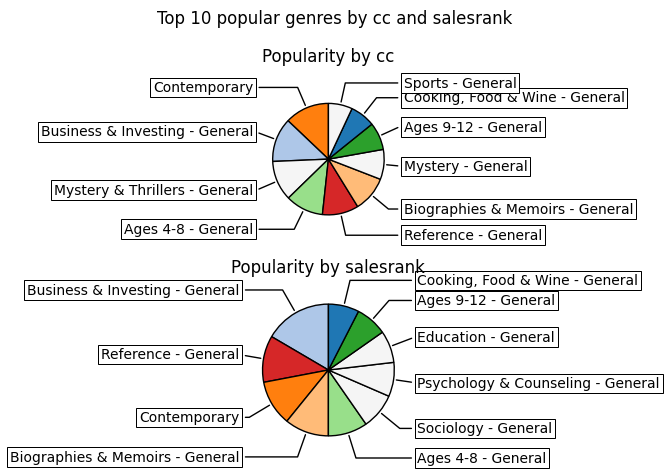

In [53]:
all_labels = set(plot_pop_genres_cc.keys()).intersection(plot_pop_genres_sr.keys())
diff_labels = set(plot_pop_genres_cc.keys()).symmetric_difference(plot_pop_genres_sr.keys())

colors = plt.cm.tab20(range(len(all_labels)))
color_map = {label: colors[i] for i, label in enumerate(all_labels)}


for label in diff_labels:
    color_map[label] = "whitesmoke"

fig, axs = plt.subplots(2)

fig.suptitle(f'Top {k} popular genres by cc and salesrank')

wedges, texts = axs[0].pie(plot_pop_genres_cc.values(), colors=[color_map[label] for label in plot_pop_genres_cc.keys()],
           startangle=90, wedgeprops = {"edgecolor" : "black",
                      'linewidth': 1,
                      'antialiased': True},
           )
axs[0].set_title('Popularity by cc', pad=20)

bbox_props = dict(boxstyle="square, pad=0.2", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

wedge_cc_labels = [label for label in plot_pop_genres_cc.keys()]

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    axs[0].annotate(wedge_cc_labels[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)


wedges, texts = axs[1].pie(plot_pop_genres_sr.values(), colors=[color_map[label] for label in plot_pop_genres_sr.keys()],
           startangle=90, wedgeprops = {"edgecolor" : "black",
                      'linewidth': 1,
                      'antialiased': True})
axs[1].set_title('Popularity by salesrank', pad=20)

wedge_sr_labels = [label for label in plot_pop_genres_sr.keys()]

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    axs[1].annotate(wedge_sr_labels[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)

plt.axis('equal')

plt.tight_layout()

plt.savefig("popularity for genres")

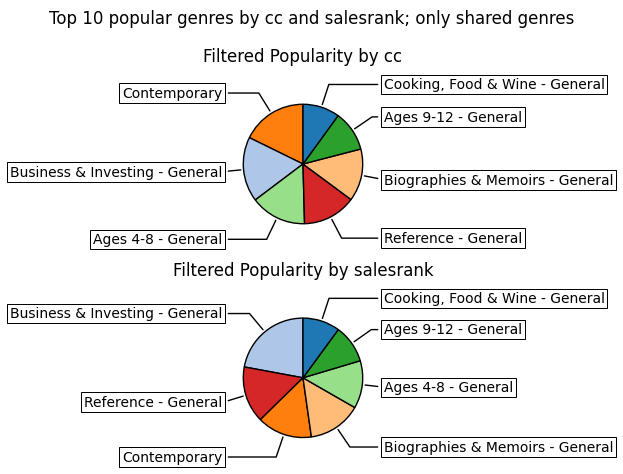

In [54]:
filtered_cc = {key: value for key, value in plot_pop_genres_cc.items() if key in all_labels}
filtered_sr = {key: value for key, value in plot_pop_genres_sr.items() if key in all_labels}

colors = plt.cm.tab20(range(len(all_labels)))
color_map = {label: colors[i] for i, label in enumerate(all_labels)}

fig, axs = plt.subplots(2)

fig.suptitle(f'Top {k} popular genres by cc and salesrank; only shared genres')

wedges, texts = axs[0].pie(filtered_cc.values(), colors=[color_map[label] for label in filtered_cc.keys()],
           startangle=90, wedgeprops = {"edgecolor" : "black",
                      'linewidth': 1,
                      'antialiased': True})

axs[0].set_title('Filtered Popularity by cc', pad=20)

wedge_cc_labels = [key for key, value in plot_pop_genres_cc.items() if key in all_labels]

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    axs[0].annotate(wedge_cc_labels[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)

wedges, texts = axs[1].pie(filtered_sr.values(), colors=[color_map[label] for label in filtered_sr.keys()],
           startangle=90, wedgeprops = {"edgecolor" : "black",
                      'linewidth': 1,
                      'antialiased': True})
axs[1].set_title('Filtered Popularity by salesrank', pad=20)

wedge_sr_labels = [key for key, value in plot_pop_genres_sr.items() if key in all_labels]

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    axs[1].annotate(wedge_sr_labels[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)

plt.tight_layout()

plt.savefig("Filtered popularity for genres")

In [55]:
pop_nodes_by_level = [[]]
level = 0
for node in cat_Tree.expand_tree(cat_Tree.root, mode=2, reverse=True, key=lambda x: node_pop(x, "high", "cc"), sorting=True):
  if cat_Tree.depth(node) != level:
    pop_nodes_by_level.append([])
    level = cat_Tree.depth(node)
  pop_nodes_by_level[level].append(node)

i = 0
for level in pop_nodes_by_level:
  print(f'Level {i} top 5:', level[:5])
  i+=1

Level 0 top 5: ['Books']
Level 1 top 5: ['Subjects[1000]']
Level 2 top 5: ["Children's Books[4]", 'Religion & Spirituality[22]', 'Literature & Fiction[17]', 'Health, Mind & Body[10]', 'Nonfiction[53]']
Level 3 top 5: ['Literature[2966]', 'People & Places[3020]', 'Ages 4-8[2785]', 'Authors & Illustrators, A-Z[170540]', 'Baby-3[2752]']
Level 4 top 5: ['Science Fiction, Fantasy, Mystery & Horror[3013]', 'Humorous[3003]', 'Action & Adventure[2967]', 'Fairy Tales, Folk Tales & Myths[2977]', 'Classics by Age[2970]']
Level 5 top 5: ['Science Fiction, Fantasy, & Magic[3017]', 'Mysteries, Espionage, & Detectives[3016]', 'Spine-Chilling Horror[3018]', 'Comics & Graphic Novels[3014]', 'Stories[3002]']
Level 6 top 5: ['Native American[2982]', 'General[2981]', 'African American[2980]', 'Staff Favorites[2983]', 'World[3001]']
Level 7 top 5: ['Gallant, Mavis[10355]', 'Urquhart, Jane[10388]', 'Ormsby, Eric[1044380]', 'Smart, Elizabeth[1044334]', 'Service, Robert W.[1044330]']


This blocks allows to do the above for just a specific genre

In [56]:
for cat in pop_nodes_by_level[1]:
  subcat_list = []
  for subcat in pop_nodes_by_level[2]:
    if cat == cat_Tree.parent(subcat).identifier:
      subcat_list.append(subcat)
  print(f'Popularity under {cat} (tot: {len(subcat_list)})', subcat_list[:14])

Popularity under Subjects[1000] (tot: 30) ["Children's Books[4]", 'Religion & Spirituality[22]', 'Literature & Fiction[17]', 'Health, Mind & Body[10]', 'Nonfiction[53]', 'Mystery & Thrillers[18]', 'Business & Investing[3]', 'Professional & Technical[173507]', 'Home & Garden[48]', 'Computers & Internet[5]', 'Reference[21]', 'Biographies & Memoirs[2]', 'Entertainment[86]', 'History[9]']


Analysis of popularity for the children (subgenres) of a given node (genre) in the tree

In [57]:
def popularity_child(node_id, most_mode = True):
  """
    function that returns the data associated to the children of the given node_id
    given the specified mode (most/least popular)
  """
  result_cc = {}
  result_sr = {}
  children = cat_Tree.children(node_id)

  if len(children) == 0:
    return [result_cc, result_sr]

  mode = "high" if most_mode else "low"

  children.sort(key = lambda x: node_pop(x, mode, "cc"), reverse = True)

  for i in range(len(children) if len(children) < 10 else 10):
    result_cc[children[i].tag] = node_pop(children[i], mode, "cc")

  children.sort(key = lambda x: node_pop(x, mode, "salesrank"), reverse = True)

  for i in range(len(children) if len(children) < 10 else 10):
    result_sr[children[i].tag] = node_pop(children[i], mode, "salesrank")


  return [result_cc, result_sr]

In [58]:
name_node = "Business & Investing"
most_mode = True

for node in cat_Tree.all_nodes():
  if node.tag == name_node:
    print("First corresponding identifier found: ", node.identifier)
    res_subGenre_analysis_cc, res_subGenre_analysis_sr = popularity_child(node.identifier, most_mode)

    print(f'----- {"Most" if most_mode else "Least"} popular category children of {cat_Tree.get_node(node.identifier).tag} using cc-----')
    for key in res_subGenre_analysis_cc:
      print(f'{key}: {res_subGenre_analysis_cc[key]}')

    print('\n')
    print(f'----- {"Most" if most_mode else "Least"} popular category children of {cat_Tree.get_node(node.identifier).tag} using salesrank-----')
    for key in res_subGenre_analysis_sr:
      print(f'{key}: {res_subGenre_analysis_sr[key]}')

    break

First corresponding identifier found:  Business & Investing[3]
----- Most popular category children of Business & Investing using cc-----
General: 2779
Management & Leadership: 1449
Industries & Professions: 1438
Economics: 847
Small Business & Entrepreneurship: 813
Careers: 776
Marketing & Sales: 727
Investing: 658
Business Life: 468
Reference: 443


----- Most popular category children of Business & Investing using salesrank-----
General: 6397
Management & Leadership: 3929
Industries & Professions: 2863
Economics: 2014
Small Business & Entrepreneurship: 1999
Marketing & Sales: 1683
Investing: 1534
Careers: 1475
Business Life: 1220
Reference: 912


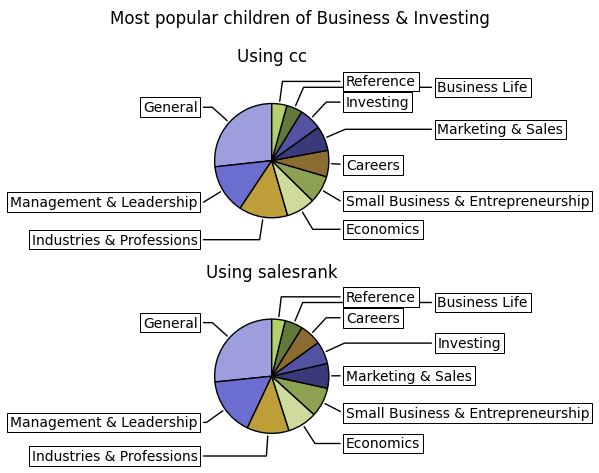

In [59]:
all_labels = set(res_subGenre_analysis_cc.keys()).intersection(res_subGenre_analysis_sr.keys())
diff_labels = set(res_subGenre_analysis_cc.keys()).symmetric_difference(res_subGenre_analysis_sr.keys())

colors = plt.cm.tab20b(range(len(all_labels)))
color_map = {label: colors[i] for i, label in enumerate(all_labels)}
for label in diff_labels:
  color_map[label] = "white"

fig, axs = plt.subplots(2)

fig.suptitle(f'{"Most" if most_mode else "Least"} popular children of {cat_Tree.get_node(node.identifier).tag}')

wedges, texts = axs[0].pie(res_subGenre_analysis_cc.values(), colors=[color_map[label] for label in res_subGenre_analysis_cc.keys()],
            startangle=90 , wedgeprops = {"edgecolor" : "black",
                      'linewidth': 1,
                      'antialiased': True})

axs[0].set_title('Using cc', pad=20)

wedge_cc_labels = [key for key in res_subGenre_analysis_cc.keys()]

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    axs[0].annotate(wedge_cc_labels[i], xy=(x, y), xytext=((1.3 if i%2==1 or i < 6 else 2.9)*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)

wedges, texts = axs[1].pie(res_subGenre_analysis_sr.values(), colors=[color_map[label] for label in res_subGenre_analysis_sr.keys()],
            startangle=90, wedgeprops = {"edgecolor" : "black",
                      'linewidth': 1,
                      'antialiased': True})

axs[1].set_title('Using salesrank', pad=20)

wedge_sr_labels = [key for key in res_subGenre_analysis_sr.keys()]

previous_x = 0
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    axs[1].annotate(wedge_sr_labels[i], xy=(x, y), xytext=((1.3 if i%2==1 or i < 6 else 2.9)*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)

plt.tight_layout()

plt.savefig("popular genre under business books")

## NDCG score analysis

In [60]:
from sklearn.metrics import ndcg_score

cc_genre_scores = []
sr_genre_scores = []

leaves = cat_Tree.leaves()
leaves.sort(key = lambda x: node_pop(x, "high", "cc"), reverse = True)
for node in leaves:
  cc_genre_scores.append(node_pop(node, "high", "cc"))
  sr_genre_scores.append(node_pop(node, "high", "salesrank"))

ndcg = ndcg_score([sr_genre_scores], [cc_genre_scores])
print("NDCG score for genre popularity: ", ndcg)

books_sr_cc = []
for book in dictionary.keys():
  if int(dictionary[book][1]) >= 0:
    books_sr_cc.append([int(dictionary[book][1]), clust[book]])

books_sr_cc.sort(key = lambda x: x[1], reverse = True)
sr_scores = []
cc_scores = []
for sr_cc_pair in books_sr_cc:
  sr_scores.append(sr_cc_pair[0])
  cc_scores.append(sr_cc_pair[1])

ndcg = ndcg_score([sr_scores], [cc_scores])
print("NDCG score for books popularity: ", ndcg)

NDCG score for genre popularity:  0.977955619383814
NDCG score for books popularity:  0.8856677296767952


In [61]:
# binary relevance assessment
sr_bin_scores = [1 if score <= sr_bounds[1] else 0 for score in sr_scores]
cc_bin_scores = [1 if score >= sr_bounds[0] else 0 for score in cc_scores]

ndcg = ndcg_score([sr_bin_scores], [cc_bin_scores])
print("NDCG score for books popularity with binary relevance assessment: ", ndcg)

NDCG score for books popularity with binary relevance assessment:  0.9053443457230609


## Joint popularity analysis

We need to define a variation of the tree function to consider the joint values

In [62]:
joint_Tree = get_tree_categories(path_file)

In [63]:
def reset_joint_tree(t):
  for node in t.all_nodes():
    node.data = {"popular": 0, "standalone": 0, "central": 0, "unpopular": 0}

def build_joint_popularity_tree(t, cc_bounds = [0, 0], sr_bounds = [0, 0]):
  """
   Function that builds the popularity tree starting from the tree of
   categories as before but here the payload is the number of books under that
   genre for each joint definition
  """

  reset_joint_tree(t)

  pop_counter = 0
  unpop_counter = 0
  standalone_counter = 0
  central_counter = 0
  for book in dictionary:

    sr_pop = salesrank_popularity(book, sr_bounds[0], sr_bounds[1])
    cc_pop = cc_popularity(book, cc_bounds[0], cc_bounds[1])

    if not sr_pop and not cc_pop:
      continue
    if sr_pop == "high" and cc_pop == "high":
      pop_counter += 1
    elif sr_pop == "high" and cc_pop == "low":
      standalone_counter += 1
    elif sr_pop == "low" and cc_pop == "low":
      unpop_counter += 1
    elif sr_pop == "low" and cc_pop == "high":
      central_counter += 1

    n_cat = len(dictionary[book][2])
    for i in range(n_cat):
      current_cat = dictionary[book][2][i]
      while current_cat != t.root:
        if t.contains(current_cat):
          data = t.get_node(current_cat).data
          if sr_pop == "high" and cc_pop == "high":
            data["popular"] += 1
          elif sr_pop == "high" and cc_pop == "low":
            data["standalone"] += 1
          elif sr_pop == "low" and cc_pop == "low":
            data["unpopular"] += 1
          elif sr_pop == "low" and cc_pop == "high":
            data["central"] += 1

          t.get_node(current_cat).data = data
          current_cat = t.parent(current_cat).identifier
        else:
          print(current_cat)
          return 0
  tot = pop_counter + standalone_counter + central_counter + unpop_counter
  print(f'Valid entries (not average) for books: {tot} out of {len(dictionary)}; \n Percentages:\n Popular: {pop_counter / tot}\n Unpopular: {unpop_counter / tot}\n Standalone: {standalone_counter / tot}\n Central: {central_counter / tot}')

In [64]:
build_joint_popularity_tree(joint_Tree, cc_bounds, sr_bounds)

Valid entries (not average) for books: 228895 out of 393561; 
 Percentages:
 Popular: 0.1227855566963018
 Unpopular: 0.5098494943096179
 Standalone: 0.3188623604709583
 Central: 0.048502588523121955


In [65]:
plot_joint_pop = {}

j_leaves = joint_Tree.leaves()

j_leaves.sort(key = lambda x: x.data['popular'], reverse = True)

for l in j_leaves[:20]:
    tag = l.tag
    if tag == "General":
      tag = f'{cat_Tree.parent(l.identifier).tag} - {tag}'
    print(f'{tag}: {l.data}')
    plot_joint_pop[tag] = l.data

Contemporary: {'popular': 1165, 'standalone': 2112, 'central': 470, 'unpopular': 3053}
Business & Investing - General: {'popular': 1131, 'standalone': 3893, 'central': 363, 'unpopular': 5542}
Mystery & Thrillers - General: {'popular': 1104, 'standalone': 839, 'central': 351, 'unpopular': 1172}
Biographies & Memoirs - General: {'popular': 842, 'standalone': 2621, 'central': 297, 'unpopular': 3191}
Reference - General: {'popular': 840, 'standalone': 2554, 'central': 361, 'unpopular': 4451}
Mystery - General: {'popular': 807, 'standalone': 597, 'central': 284, 'unpopular': 899}
Ages 4-8 - General: {'popular': 765, 'standalone': 1870, 'central': 543, 'unpopular': 3308}
Cooking, Food & Wine - General: {'popular': 764, 'standalone': 1352, 'central': 112, 'unpopular': 1203}
Romance - General: {'popular': 763, 'standalone': 548, 'central': 134, 'unpopular': 879}
Self-Help - General: {'popular': 711, 'standalone': 1327, 'central': 131, 'unpopular': 964}
Ages 9-12 - General: {'popular': 644, 'st

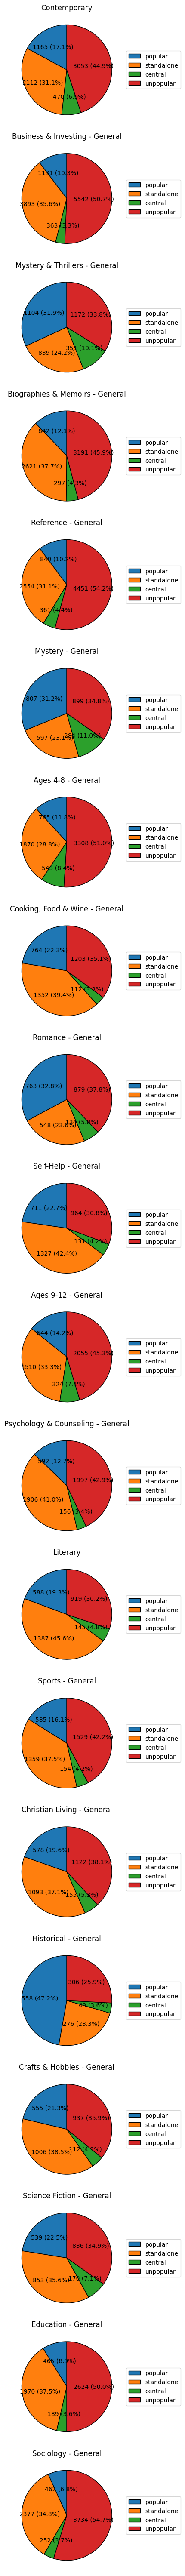

In [66]:
sorted_plot_joint_pop = dict(sorted(plot_joint_pop.items(), key=lambda item: item[1]['popular'], reverse=True))

fig, axs = plt.subplots(len(sorted_plot_joint_pop.keys()), figsize=(40, 60))
i = 0
for key in sorted_plot_joint_pop:
    data = sorted_plot_joint_pop[key]

    axs[i].pie(
        data.values(),
        startangle=90,
        autopct=lambda pct: f"{int(round(pct * sum(data.values()) / 100))} ({pct:.1f}%)",
        wedgeprops = {"edgecolor" : "black",
                      'linewidth': 1,
                      'antialiased': True})

    axs[i].legend(
        [f"{label}" for label in data.keys()],
        loc="center left",
        bbox_to_anchor=(1, 0.5))

    axs[i].set_title(key)
    i += 1

plt.tight_layout()

plt.show()

Take only one of the previous plot to put it in the report

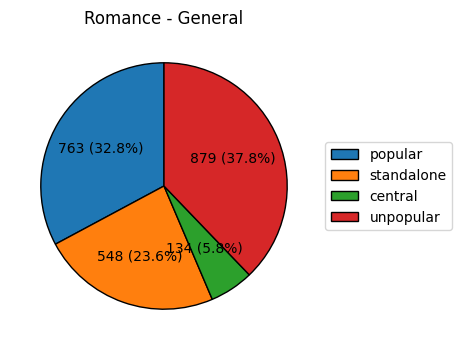

In [67]:
#last_key = list(sorted_plot_joint_pop.keys())[-1]
last_key = 'Romance - General'
data = sorted_plot_joint_pop[last_key]

fig, ax = plt.subplots(figsize=(5, 4))

ax.pie(
    data.values(),
    startangle=90,
    autopct=lambda pct: f"{int(round(pct * sum(data.values()) / 100))} ({pct:.1f}%)",
    wedgeprops = {"edgecolor" : "black",
                      'linewidth': 1,
                      'antialiased': True}
)

ax.legend(
    [f"{label}" for label in data.keys()],
    loc="center left",
    bbox_to_anchor=(1, 0.5),
)

ax.set_title(last_key)

plt.savefig("joint for contemporary")